In [14]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [32]:
# Utils
import matplotlib.pyplot as plt
import numpy as np

def plot_time_series(time_series, prediction, title='Time Series with Quantiles'):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    plt.plot(prediction, label='Predition', color='orange')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_time_series_with_errors_area(time_series, prediction, error_low, error_high):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    plt.plot(prediction, label='Predition', color='orange')
    plt.fill_between(np.arange(0, len(time_series)), error_low, error_high, alpha=0.3)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_time_series_with_quantiles(time_series, quantiles, seq_length, title='Time Series with Quantiles'):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    
    # Plot the quantiles
    for index in range(0, len(quantiles)//2):
        print(quantiles[index])
        print(quantiles[len(quantiles)-index-1])
        plt.fill_between(np.arange(0, len(time_series)), 
                         quantiles[index], quantiles[len(quantiles)-index-1], label=f'Quantile {index+1}', alpha=0.3)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



In [15]:
data = pd.read_csv('./../data/throughput.csv')

In [108]:
values = data['sum_call_count'].values
values = values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(values)

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 144
X = create_sequences(values_scaled, seq_length)
X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X, X)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [5]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super(QuantileLoss, self).__init__()
        self.quantiles = quantiles

    def forward(self, y_pred, y_true):
        losses = []
        for q in self.quantiles:
            errors = y_true - y_pred
            loss = torch.max((q-1) * errors, q * errors)
            losses.append(loss.unsqueeze(0))
        loss = torch.mean(torch.cat(losses, dim=0), dim=0)
        return torch.mean(loss)

quantiles = [0.02, 0.1, 0.4, 0.5, 0.6, 0.9, 0.98]
quantile_loss = QuantileLoss(quantiles)


In [121]:
class ConvAutoencoder(pl.LightningModule):
    def __init__(self, loss, hidden_size):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_size, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=0),    
            nn.Conv1d(hidden_size, hidden_size//2, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, padding=0)     
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden_size//2, hidden_size//2, 3, padding=1), 
            nn.ReLU(),
            nn.Upsample(scale_factor=2),   
            nn.Conv1d(hidden_size//2, hidden_size, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),   
            nn.Conv1d(hidden_size, 1, 3, padding=1),
        )
        self.loss_fn = loss
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        inputs, _ = batch
        outputs = self(inputs.permute(0, 2, 1))
        loss = self.loss_fn(outputs, inputs.permute(0, 2, 1))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)


In [122]:
inputs = dataset[600][0].permute(1, 0).unsqueeze(0)
model.eval()
with torch.no_grad():
    predictions = model(inputs)  # Shape: (1, n_quantiles, seq_length)


In [123]:
predictions.shape

torch.Size([1, 1, 142])

In [110]:
model = ConvAutoencoder(nn.MSELoss(), hidden_size=32)
trainer = pl.Trainer(max_epochs=50, logger=True, log_every_n_steps=1)
trainer.fit(model, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.6 K 
1 | decoder | Sequential | 2.4 K 
2 | loss_fn | MSELoss    | 0     
---------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated model params size (MB)
d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/1348 [00:00<?, ?it/s] 

d:\courses\MLsimulator\venv\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32, 1, 144])) that is different to the input size (torch.Size([32, 1, 142])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (142) must match the size of tensor b (144) at non-singleton dimension 2

In [99]:
inputs = dataset[600][0].permute(1, 0)
model.eval()
with torch.no_grad():
    predictions = model(inputs.unsqueeze(0)).squeeze(0).squeeze(0)  # Shape: (1, n_quantiles, seq_length)


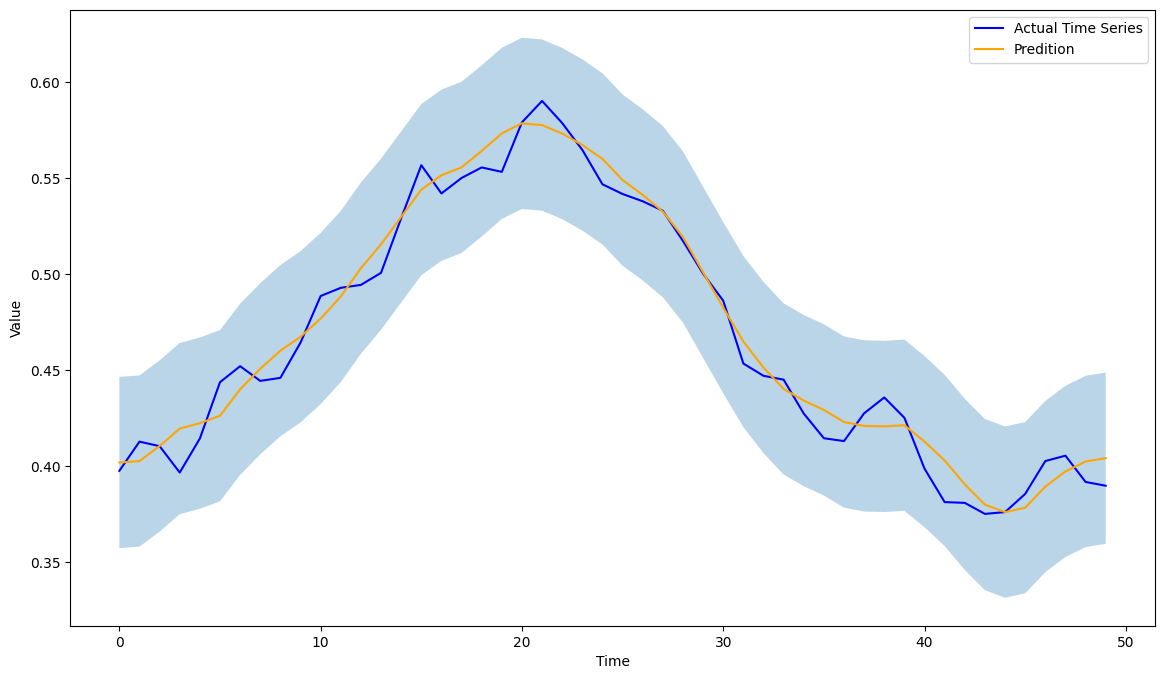

In [71]:
x = inputs.squeeze(0).numpy()
pred = predictions.numpy()

reconstruction_errors = np.abs(pred - x)*2
threshold = np.quantile(reconstruction_errors, 0.99)

plot_time_series_with_errors_area(x, pred, pred - threshold, pred + threshold)

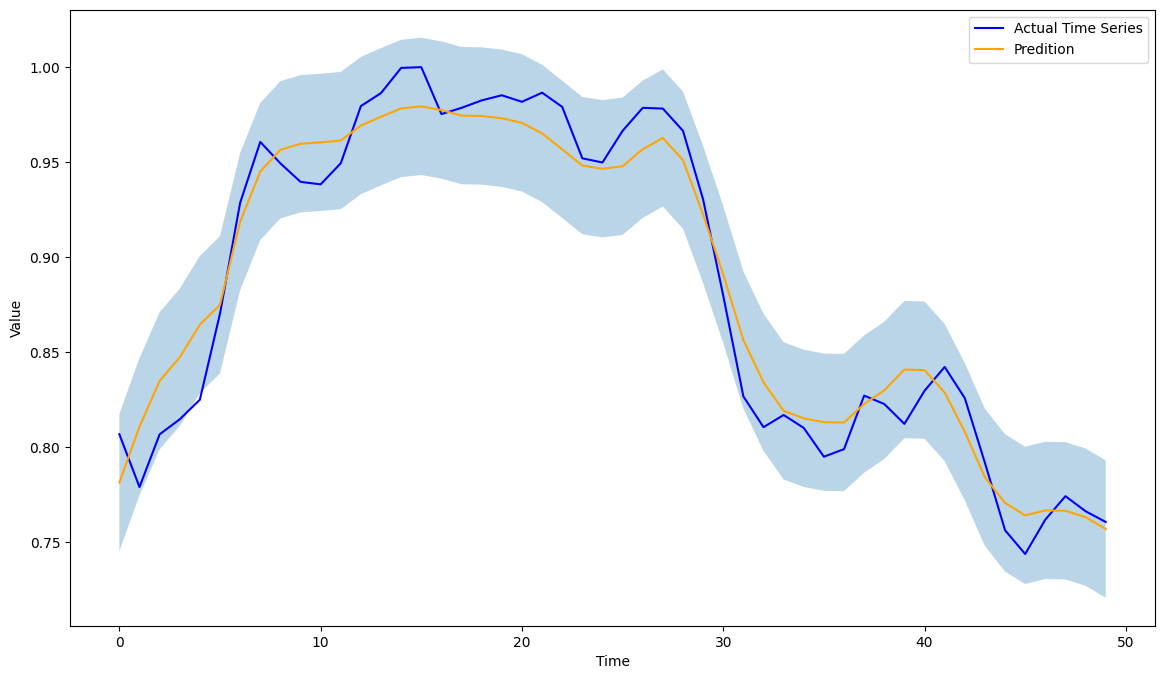

In [104]:
outlier = torch.FloatTensor(scaler.transform(np.array(data["sum_call_count"][15350:15400]).reshape(-1,1))).permute(1,0)
model.eval()
with torch.no_grad():
    predictions = model(outlier.unsqueeze(0)).squeeze(0).squeeze(0)  # Shape: (1, n_quantiles, seq_length)

x = outlier.squeeze(0).numpy()
pred = predictions.numpy()

reconstruction_errors = np.abs(pred - x)
threshold = np.quantile(reconstruction_errors, 0.99)

plot_time_series_with_errors_area(x, pred, pred - threshold, pred + threshold)

Other

In [8]:
class LSTMAutoencoder(pl.LightningModule):
    def __init__(self, input_dim, seq_len, hidden_dim=128, dropout_rate=0.2, quantile_loss=QuantileLoss([0.1, 0.5, 0.9])):
        super(LSTMAutoencoder, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        
        self.repeat_vector = nn.Parameter(torch.empty(seq_len, hidden_dim))
        nn.init.uniform_(self.repeat_vector)
        
        self.lstm2 = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(p=dropout_rate)
        self.dense = nn.Linear(hidden_dim, len(quantile_loss.quantiles))
        self.quantile_loss = quantile_loss
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        
        # Use the last output of the first LSTM
        x = x[:, -1, :]  # Take the last output of the first LSTM
        x = x.unsqueeze(1).repeat(1, self.repeat_vector.size(0), 1)  # Repeat the last output for each time step
        
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        x = self.dense(x)
        return x

    def training_step(self, batch, batch_idx):
        x, _ = batch
        y_pred = self(x)
        loss = self.quantile_loss(y_pred, x)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

In [9]:
input_dim = 1
hidden_dim = 64
seq_len = 50
max_epochs=30
num_layers = 2

model = LSTMAutoencoder(input_dim, seq_len, hidden_dim=128, dropout_rate=0.2, quantile_loss=quantile_loss)
trainer = pl.Trainer(max_epochs=max_epochs, logger=True, log_every_n_steps=1)
trainer.fit(model, dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name          | Type         | Params
-----------------------------------------------
0 | lstm1         | LSTM         | 67.1 K
1 | dropout1      | Dropout      | 0     
2 | lstm2         | LSTM         | 132 K 
3 | dropout2      | Dropout      | 0     
4 | dense         | Linear       | 903   
5 | quantile_loss | Qu

Epoch 1:  87%|████████▋ | 1173/1351 [00:50<00:07, 23.12it/s, v_num=14, train_loss_step=0.0164, train_loss_epoch=0.0275]

d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [11]:
inputs = dataset[0][0].permute(1, 0)
model.eval()
with torch.no_grad():
    quantile_predictions = model(inputs.unsqueeze(0))  # Shape: (1, n_quantiles, seq_length)
